In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import olla

/private/home/melhoushi/miniconda3/envs/olla_2.0/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class SimpleModule(torch.nn.Module):
    def __init__(self):
        super(SimpleModule, self).__init__()
        self.v1 = V1()
        self.v3 = V3()
        self.v2 = V2()
        self.v4 = V4()

    def forward(self, e1):
        e3, e2 = self.v1(e1)
        e4 = self.v3(e2)
        e5 = self.v2(e3)
        e6 = self.v4(e4, e5)
        return e6

class V1(torch.nn.Module):
    def forward(self, e1):
        e2 = e1.clone()
        e3 = torch.cat([e1, e1])
        return e3, e2

class V2(torch.nn.Module):
    def forward(self, e3):
        e5 = e3[0::4].clone()
        return e5

class V3(torch.nn.Module):
    def forward(self, e2):
        e4 = torch.cat([e2, e2, e2])
        return e4

class V4(torch.nn.Module):
    def forward(self, e4, e5):
        e6 = torch.cat([e5, e4[::6]])
        return e6


In [3]:
model = None
input = None

# Eager

In [3]:
model = SimpleModule().cuda()
input = torch.rand(10*1024*1024 // 4).cuda()

In [4]:
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
torch.cuda.memory._record_memory_history(True, trace_alloc_max_entries=100000, trace_alloc_record_context=True)

In [5]:
model(input)

tensor([0.0496, 0.7619, 0.6431,  ..., 0.1331, 0.1525, 0.4393], device='cuda:0')

In [6]:
from pprint import pprint
snapshot = torch.cuda.memory._snapshot()
# pprint(snapshot)
from pickle import dump
dump(snapshot, open('snapshot_eager.pickle', 'wb'))

In [7]:
!python _memory_viz.py trace_plot snapshot_eager.pickle -o snapshot_eager.html

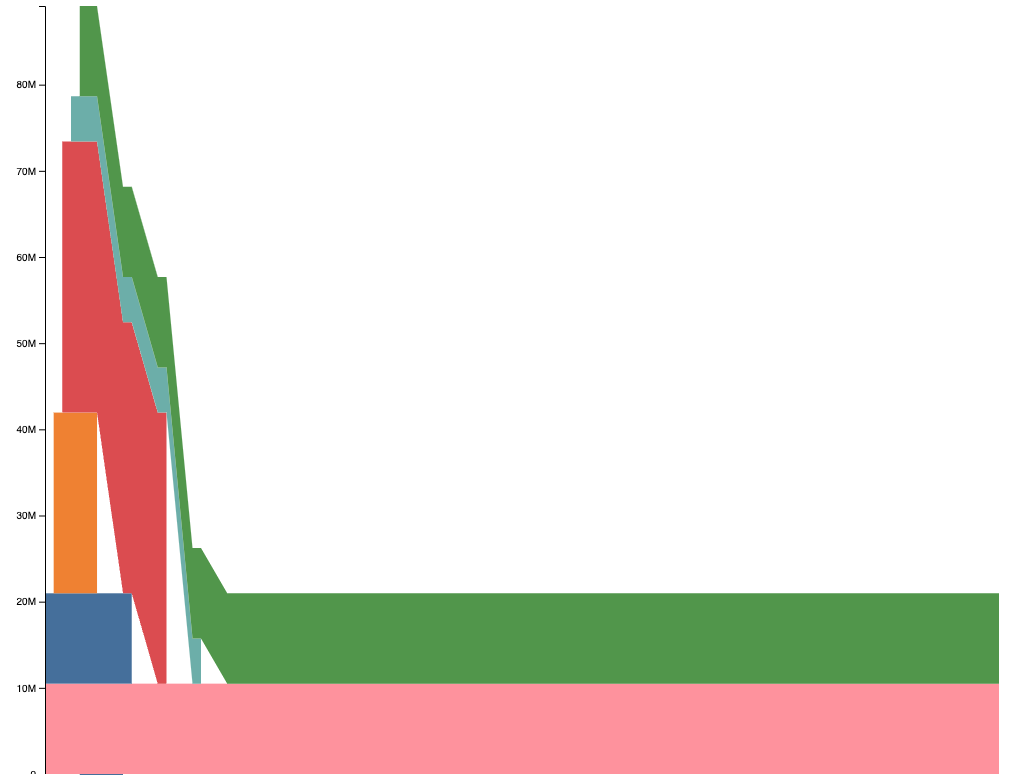


You can view an interactive version of the trace [here](https://www.dropbox.com/s/hmug3fj8l5e9zum/snapshot_eager.html?dl=0).

# Compiled Mode: torch.fx

NOTE: Need to restart the Notebook and run the above cells without the "Eager" section.


TODO: Check with Zachary how to reset memory and stats.

In [9]:
if model:
    del model
    model = None
if input:
    del input
    input = None

model = SimpleModule().cuda()
input = torch.rand(10*1024*1024 // 4).cuda()

In [10]:
from torch.fx import symbolic_trace
model = symbolic_trace(model)
print(model.code)




def forward(self, e1):
    clone = e1.clone()
    cat = torch.cat([e1, e1]);  e1 = None
    cat_1 = torch.cat([clone, clone, clone]);  clone = None
    getitem = cat[slice(0, None, 4)];  cat = None
    clone_1 = getitem.clone();  getitem = None
    getitem_1 = cat_1[slice(None, None, 6)];  cat_1 = None
    cat_2 = torch.cat([clone_1, getitem_1]);  clone_1 = getitem_1 = None
    return cat_2
    


In [11]:
model.graph.print_tabular()

opcode         name       target                                                  args                           kwargs
-------------  ---------  ------------------------------------------------------  -----------------------------  --------
placeholder    e1         e1                                                      ()                             {}
call_method    clone      clone                                                   (e1,)                          {}
call_function  cat        <built-in method cat of type object at 0x7ff639d55540>  ([e1, e1],)                    {}
call_function  cat_1      <built-in method cat of type object at 0x7ff639d55540>  ([clone, clone, clone],)       {}
call_function  getitem    <built-in function getitem>                             (cat, slice(0, None, 4))       {}
call_method    clone_1    clone                                                   (getitem,)                     {}
call_function  getitem_1  <built-in function getitem>         

In [12]:
drawing = torch.fx.passes.graph_drawer.FxGraphDrawer(model, "orig_fx")
with open("orig_fx.svg", "wb") as f:
    f.write(drawing.get_dot_graph().create_svg())
with open("orig_fx.png", "wb") as f:
    f.write(drawing.get_dot_graph().create_png())

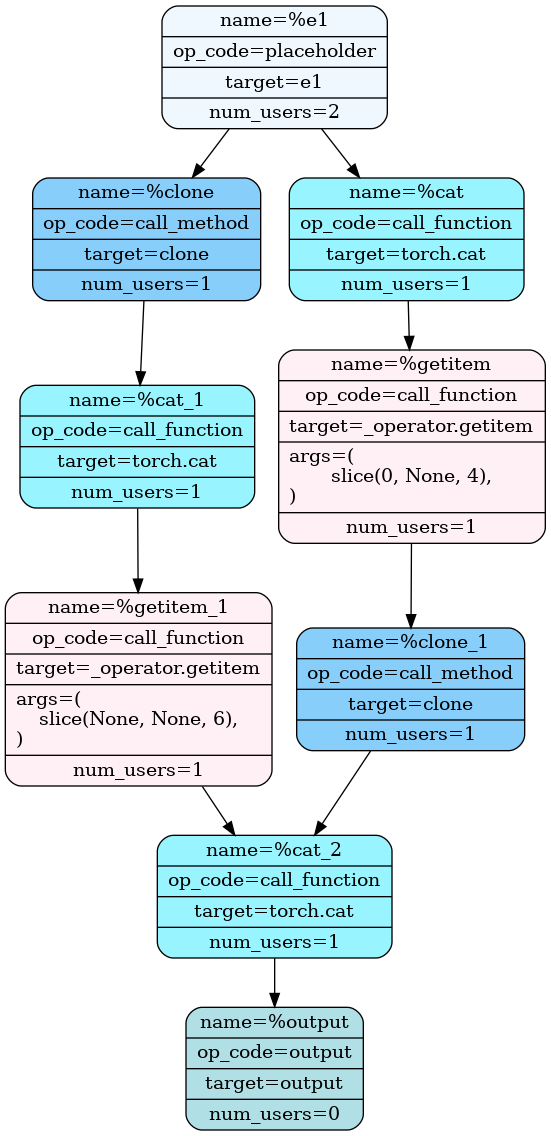

In [13]:
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
torch.cuda.memory._record_memory_history(True, trace_alloc_max_entries=100000, trace_alloc_record_context=True)

In [14]:
model(input)

tensor([0.1996, 0.2193, 0.2290,  ..., 0.6276, 0.5618, 0.3442], device='cuda:0')

In [15]:
from pprint import pprint
snapshot = torch.cuda.memory._snapshot()
# pprint(snapshot)
from pickle import dump
dump(snapshot, open('snapshot_fx.pickle', 'wb'))

In [16]:
!python _memory_viz.py trace_plot snapshot_fx.pickle -o snapshot_fx.html

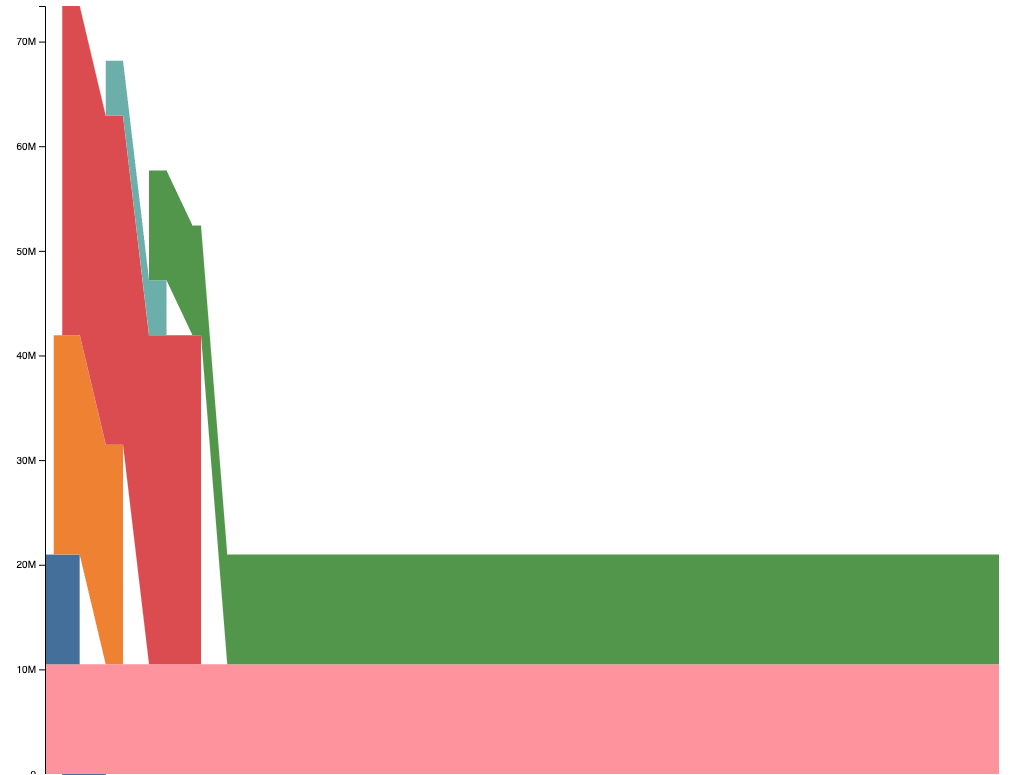

You can view an interactive version of the trace [here](https://www.dropbox.com/s/64j1rg6rqvulgml/snapshot_fx.html?dl=0)

# OLLA

In [4]:
if model:
    del model
    model = None
if input:
    del input
    input = None

model = SimpleModule().cuda()
input = torch.rand(10*1024*1024 // 4).cuda()

In [9]:
# custom tracer to treat V1, V2, V3, and V4 as ops and avoid tracing through them
class CustomTracer(torch.fx.Tracer):
    def is_leaf_module(self, m: torch.nn.Module, module_qualified_name: str) -> bool:
        return isinstance(m, V1) or isinstance(m, V2) or isinstance(m, V3) or isinstance(m, V4) 

In [23]:
importer = olla.torch.torch_graph_importer.TorchGraphImporter()
(
    g,
    pytorch_node_order,
    fx_graph,
    fx_to_df_map,
) = importer.import_via_fx(
    model,
    input,
    mode="eval",
    tracer_class=CustomTracer,
    cleanup=True,
    treat_output_as_fake=False,
    return_node_ordering=True,
    return_fx_graph=True,
)
assert(g.is_valid())
g.canonicalize()
g.constrain_weight_updates()
g.constrain_tensor_generators()
assert(g.is_valid())

node_order = str([node for node in fx_graph.graph.nodes])


MODEL STATS: #RAW NODES=8, #RAW EDGES=7
MODEL STATS: #ACTUAL OPERATORS=8, #ACTUAL TENSORS=7


In [24]:
g.dump("orig_graph", format="png")


'orig_graph'

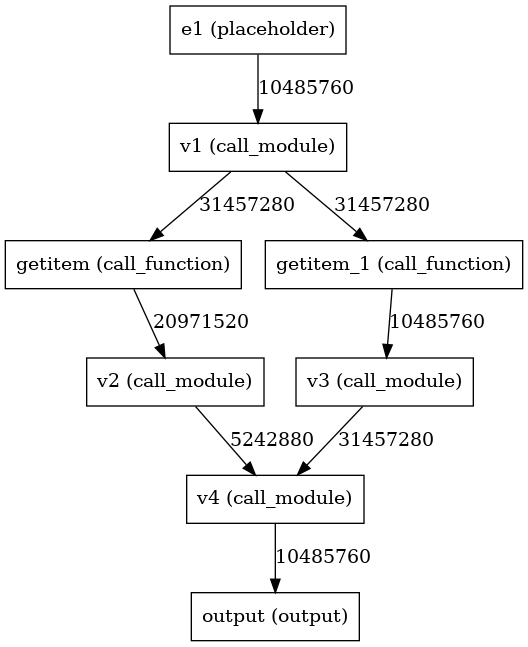

In [21]:
!source ~/.bashrc

In [22]:
s = olla.training_graph_optimizer.Scheduler(g)
summary, schedule, mem_loc = s.ComputeOptimalSchedule(
    allow_swaps=False,
    max_spills=0,
)
# print(f"SCHEDULER = {schedule}")
node_order_optimized = olla.utils.extract_node_ordering(g, schedule)

Restricted license - for non-production use only - expires 2024-10-28


--- Logging error ---
Traceback (most recent call last):
  File "/private/home/melhoushi/OLLA/olla/gurobi_utils.py", line 19, in get_gurobi_env
    int(os.getenv("OLLA_GUROBI_ISV_EXPIRATION")),
TypeError: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/private/home/melhoushi/miniconda3/envs/olla_2.0/lib/python3.10/logging/__init__.py", line 1100, in emit
    msg = self.format(record)
  File "/private/home/melhoushi/miniconda3/envs/olla_2.0/lib/python3.10/logging/__init__.py", line 943, in format
    return fmt.format(record)
  File "/private/home/melhoushi/miniconda3/envs/olla_2.0/lib/python3.10/logging/__init__.py", line 678, in format
    record.message = record.getMessage()
  File "/private/home/melhoushi/miniconda3/envs/olla_2.0/lib/python3.10/logging/__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all

In [27]:
fx_opt = olla.torch.fx_optimizer.FXOptimizer(fx_graph, fx_to_df_map)
fx_opt.Reorder(node_order_optimized)
fx_graph_opt = fx_opt.fx_trace

KeyError: e1 (placeholder)

In [ ]:
drawing = torch.fx.passes.graph_drawer.FxGraphDrawer(fx_graph_opt, "olla_fx")
with open("olla_fx.svg", "wb") as f:
    f.write(drawing.get_dot_graph().create_svg())
with open("olla_fx.png", "wb") as f:
    f.write(drawing.get_dot_graph().create_png())

In [28]:
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
torch.cuda.memory._record_memory_history(True, trace_alloc_max_entries=100000, trace_alloc_record_context=True)

In [ ]:
with torch.no_grad():
    torch.manual_seed(0)
    final_result = fx_graph_opt.forward(
        (input,),
        params=dict(model.named_parameters()),
        buffers=dict(model.named_buffers()),
    )

In [ ]:
from pprint import pprint
snapshot = torch.cuda.memory._snapshot()
# pprint(snapshot)
from pickle import dump
dump(snapshot, open('snapshot_olla.pickle', 'wb'))

In [ ]:
!python _memory_viz.py trace_plot snapshot_olla.pickle -o snapshot_olla.html